# Phase Shifts and Virtual Z gates

In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2

## Introduction

Under the right circumstances, phase shifts can be a great way of implementing so-called *virtual-Z gates*. Let's see how these arise and how we can use them to our advantage. 
Consider an arbitrary 2x2 unitary matrix (up to a global phase) and a possible decompostion in terms of rotations around the $x$ and $z$ axes ($R_X$ and $R_Z$) of the Bloch sphere: 

$$U(\gamma, \theta, \phi) =  R_Z(\gamma)R_X(\theta)R_Z(\phi)$$

Our goal is to be able to apply this transformation on our qubit states through our pulses. A pulse that is on-resonance with its target transition (i.e. has detuning $\delta = 0$) can be described as an arbitrary rotation around an axis contained in the Bloch sphere's equator, $\hat{n}= (\cos \phi, -\sin \phi, 0)$. From the general form of such a rotation, $R_{\hat{n}}(\theta) =     \exp\left(-i \frac{\theta}{2}  \hat{n}\cdot \vec{\sigma}\right)$, we arrive at:

$$
\begin{align}       
 R_{\hat{n}(\phi)}(\theta) &= \exp\left(-i \frac{\theta}{2} \left[\cos(\phi)\sigma_x -\sin(\phi)\sigma_y\right]\right)\\
          &= e^{i\frac{\phi}{2}\sigma_z}e^{-i\frac{\theta}{2}\sigma_x}e^{-i\frac{\phi}{2}\sigma_z}\\
          &=  R_Z(-\phi)R_X(\theta)R_Z(\phi)
\end{align}
$$

Here, we have two free parameters: the angle of rotation $\theta$, which is determined by the integral of the amplitude waveform, and $\phi$, the pulse's phase. Thus, we can see that a pulse is a particular case of the arbitrary single-qubit gate $U$, where $\gamma = -\phi$, i.e.:

$$ R_{\hat{n}(\phi)}(\theta) = U(-\phi, \theta, \phi) $$

Thus, to reach the desired arbitrary single-qubit, we need an extra $R_Z$ gate, such that:

$$ U(\gamma, \theta, \phi) = R_Z(\gamma + \phi) R_Z(-\phi)R_X(\theta)R_Z(\phi) = R_Z(\gamma + \phi) U(-\phi, \theta, \phi)$$

Now, how do we implement such a gate? In fact, to physically change the phase of the qubit's state in this reference frame with a single pulse, we would have to be able to apply a detuned pulse of zero amplitude, which is no pulse at all! Instead, what we can do is change the frame of rotation such that the phase gate is applied *virtually*.

To understand how this can be done, we first have to realise that this last phase gate is irrelevant if it is the last one applied to the qubit before it is measured - a change of the phase between the $\sigma_z$ eigenstates will produce no change in the measurement outcome, since that occurs in the same basis. But what if it is not the last gate that we apply on this qubit? In that case, we can describe the situation as a new arbitrary gate being applied after the existent one, i.e.

$$ U(\alpha, \beta, \nu)~~U(\gamma, \theta, \phi) = R_Z(\alpha + \nu) R_Z(-\nu)R_X(\beta)R_Z(\nu) ~~ R_Z(k)~
U(-\phi, \theta, \phi) $$

where we define the *carry*, $k=\gamma + \phi$, as the phase of the unrealized phase gate. Now, we can restructure the previous expression such that:

$$
\begin{align}
& R_Z(\alpha + \nu) R_Z(-\nu)R_X(\beta)R_Z(\nu)~~ R_Z(k) ~U(-\phi, \theta, \phi) = \\
&= R_Z(\alpha + \nu + k)~~ R_Z(-\nu - k)R_X(\beta)R_Z(\nu + k) ~~U(-\phi, \theta, \phi) \\
&= R_Z(k') ~~U(-\nu - k, \beta, \nu + k)~~U(-\phi, \theta, \phi), ~~~k' = \alpha + \nu + k
\end{align}
$$

As shown, the previously existent phase gate of angle $k$ can be realized as a **shift** on the phase of the second pulse, $\nu \rightarrow \nu + k$. In this way, we go back to a situation where we have a phase gate at the end (with an updated carry $k'$). We can repeat this process until the moment we measure the qubit, at which point, as we've seen, the remaining phase gate is redundant. 

This is the **virtual-Z gate**: the ability to perform phase gates through the adjustment of a qubit's phase reference.

## Phase shifts in Pulser

As shown above, implementing virtual-Z gates requires tracking the *carry* and adapting the phase of each provided pulse accordingly. Although this could certainly be done externally, Pulser offers a convenient way to automatically update a qubit's phase reference (i.e. the *carry*) through **phase shifts**.

A phase shift in Pulser is defined by three things: the *value* of the shift, the *target* qubits and the *basis*. A phase shift of *value* $\phi$ corresponds to a change in the *target*'s phase reference from $k \rightarrow k + \phi$.

It is important to realise that, unlike all other aspects so far, phase shifts are associated to the a qubit's transition, not a channel. Therefore, in principle, all qubit's can keep different phase references, as a result of being subjected to different phase shifts throughout a sequence.

### Programming a Hadamard gate 

To exemplify the need for phase shifts, let's try to encode an Hadamard gate using only resonant pulses.
In our decomposition of a unitary matrix, the Hadamard is (you can check this for yourself):

$$ H = U\left(\frac{\pi}{2},\frac{\pi}{2}, \frac{\pi}{2}\right) = R_Z(\pi)~~U\left(-\frac{\pi}{2},\frac{\pi}{2}, \frac{\pi}{2}\right) $$

meaning that we have to apply a $\frac{\pi}{2}$-pulse with phase $\phi=\frac{\pi}{2}$, followed by a phase shift of $\pi$.

But first, let's create a simple setup.

In [2]:
reg = Register({'q0': (0, 0)})
device = Chadoq2
seq = Sequence(reg, device)
seq.available_channels

{'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Basis: 'ground-rydberg'),
 'rydberg_local': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'ground-rydberg'),
 'rydberg_local2': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'ground-rydberg'),
 'raman_local': Raman.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'digital')}

In [3]:
seq.declare_channel('ch0', 'raman_local', initial_target = 'q0')

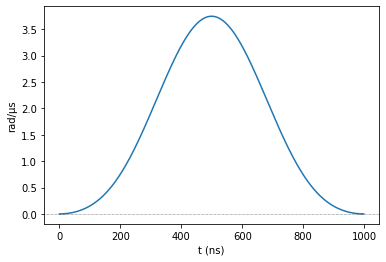

In [4]:
# Defining the waveform for a pi/2 pulse
from pulser.waveforms import BlackmanWaveform
pi2_wf = BlackmanWaveform(1000, np.pi/2)   # Duration: 1us, Area: pi/2
pi2_wf.draw()

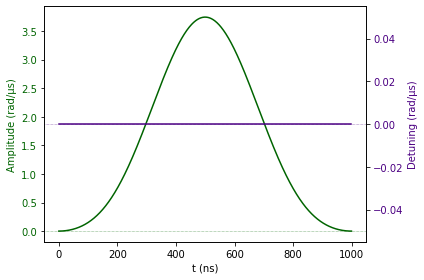

In [5]:
# 2. Create the pi/2 pulse
pi_2 = Pulse.ConstantDetuning(pi2_wf, detuning=0, phase=np.pi/2)
pi_2.draw()

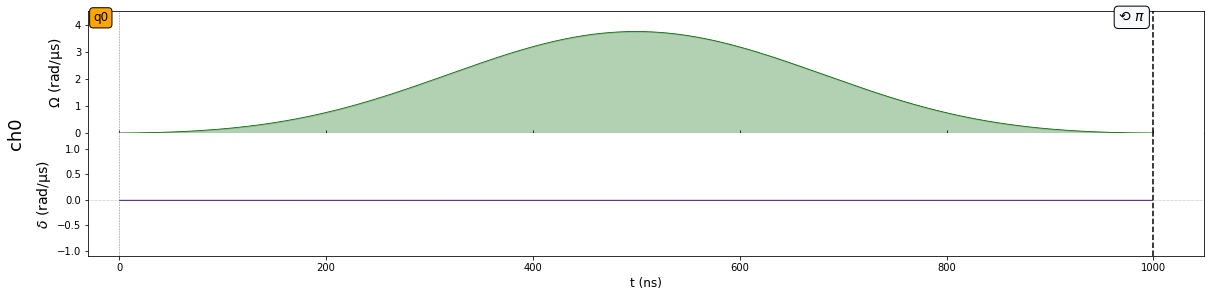

In [6]:
#3. Applying the H gate

seq.add(pi_2, 'ch0')   # The first pi/2-pulse
# Now the phase shift of pi on 'q0', for the 'digital' basis, which is usually where phase shifts are useful
seq.phase_shift(np.pi, 'q0', basis='digital') 

seq.draw()

This produced the desired effect: we have a $\frac{\pi}{2}$ pulse with $\pi=\frac{\pi}{2}$ followed by a phase shift of $\pi$. However, the need to specify the target qubit and basis is mildly incovenient. Moreover, it would be even better if the entire hadamard could be in the same pulse object. Fortunately, there's a way.

The `Pulse` object has an optional argument called `post_phase_shift`, with which the user can order a phase shift to be applied immediatly after the physical pulse. In this case, the target and basis are **implicitly defined** to be the channel's current target and basis.

Here's how we could define the Hadamard in a single pulse:

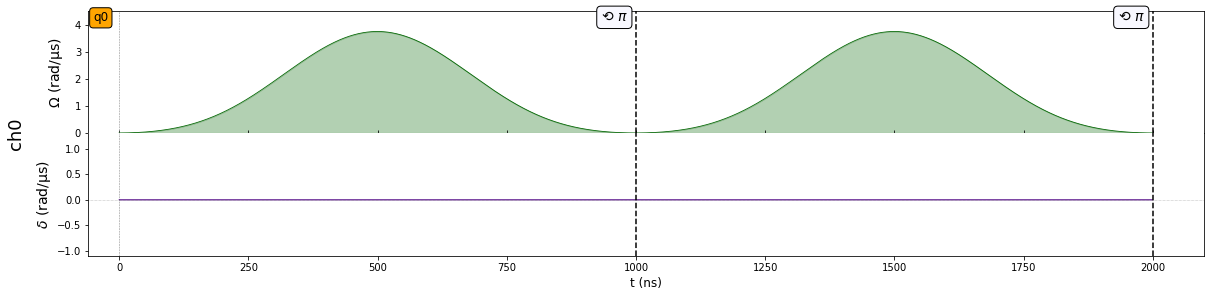

In [7]:
h = Pulse.ConstantDetuning(pi2_wf, detuning=0, phase=np.pi/2, post_phase_shift=np.pi)

seq.add(h, 'ch0')
seq.draw()

Notice how the two pulse shapes are naturally identical, and are both followed by the adequate $\pi$ phase shift. However, we expect to see an adjustment on the phase of the second pulse, simply because it is following a phase shift. To inspect the phase of each pulse, we can print the sequence:

In [8]:
print(seq)

Channel: ch0
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->1000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q0
t: 1000->2000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: q0




Here, we see that the phase of the second pulse has the appropriate adjustment of $\pi$. What happens if we apply the Hadamard yet again?

In [9]:
seq.add(h, 'ch0')
print(seq)

Channel: ch0
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->1000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q0
t: 1000->2000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: q0
t: 2000->3000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q0




That's right, the phase of the third pulse is back to $\frac{\pi}{2}$ because, at the moment the third Hadamard was constructed, there had been two $\pi$ phase shifts, which means the reference is back to $\phi=0$.

### Phase shifts with multiple channels and different targets

Now, let's construct a more complex example where there are multiple channels and multiple qubits.

In [10]:
reg = Register({'q0': (0, 0), 'q1': (5, 5)})
device = Chadoq2
seq = Sequence(reg, device)
seq.declare_channel('raman', 'raman_local', initial_target = 'q0')
seq.declare_channel('ryd1', 'rydberg_local', initial_target = 'q0')
seq.declare_channel('ryd2', 'rydberg_local2', initial_target = 'q0')
seq.declared_channels

{'raman': Raman.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'digital'),
 'ryd1': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'ground-rydberg'),
 'ryd2': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'ground-rydberg')}

We see that we have two qubits and three channels, all `Local`, with `raman` acting on the `digital` basis and the other two on the `ground-rydberg` basis. Let's use the Hadamard from before and add it to channels `raman` and `ryd1`, which are both targeting `q0` on different bases:

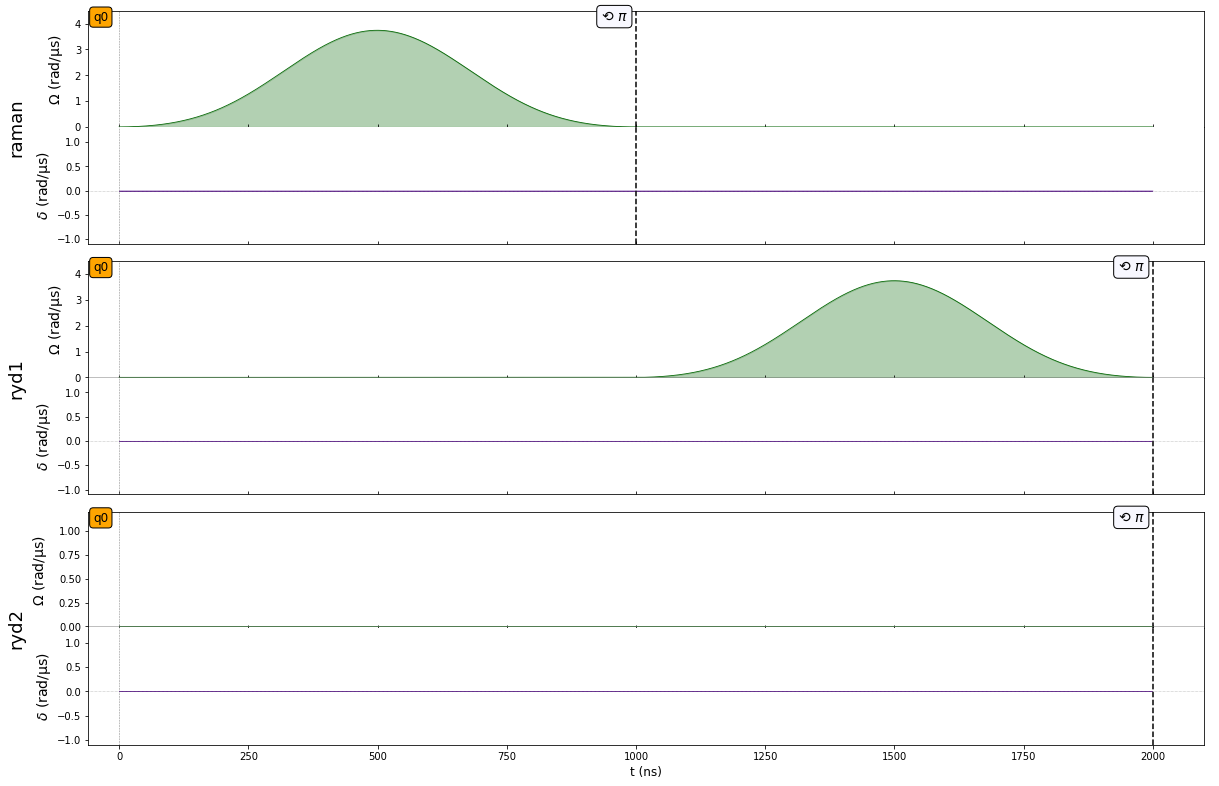

In [11]:
seq.add(h, 'raman')
seq.add(h, 'ryd1')
seq.draw()

We can see that the pulse in channel `ryd1` waited for the pulse in `raman` to be finished (because they are acting on the same target). We also noticed that the phase shift in `raman` does not appear in the other channels, the reason for that being the fact that they act on **different bases**. We can check this by printing the sequence: 

In [12]:
print(seq)

Channel: raman
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->1000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q0

Channel: ryd1
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->1000 | Delay 
t: 1000->2000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q0

Channel: ryd2
t: 0 | Initial targets: q0 | Phase Reference: 0.0 




Here, we confirm that the phase of the pulse in `ryd1` is $\frac{\pi}{2}$, which indicates a phase reference of $\phi=0$ as expected. What about when the phase shift targets the same qubit, the same basis, but the pulses are on different channels? In that case, we expect that the channel is irrelevant, and we can already see evidence of that in how the phase shift at the end of the Hadamard on `ryd1` also appears in `ryd2`. We can confirm this by adding another pulse to `ryd2` (e.g. the `pi_2` pulse we defined before) and then priting the sequence:

In [13]:
seq.add(pi_2, 'ryd2')
print(seq)

Channel: raman
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->1000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q0

Channel: ryd1
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->1000 | Delay 
t: 1000->2000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q0

Channel: ryd2
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->2000 | Delay 
t: 2000->3000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: q0




Notice how the `pi_2` pulse has a phase of $\frac{3\pi}{2}$: it's phase of $\frac{\pi}{2}$ plus the shift of $\pi$ accrued by the Hadamard in channel `ryd1`.

Let's now shift our attention torwards what happens when the basis and the channel stay the same, but the target qubit changes. By now, you can already predict that qubit `q1` has a phase reference of $\phi=0$ on both basis, since all phase shifts so far were always targeting `q0`. We can see this if we change the target on some channels and apply pulses again:

Channel: raman
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->1000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q0
t: 1000->1000 | Target: q1 | Phase Reference: 0.0
t: 1000->2000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q1

Channel: ryd1
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->1000 | Delay 
t: 1000->2000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q0
t: 2000->2000 | Target: q1 | Phase Reference: 0.0
t: 2000->3000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: q1

Channel: ryd2
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->2000 | Delay 
t: 2000->3000 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: q0




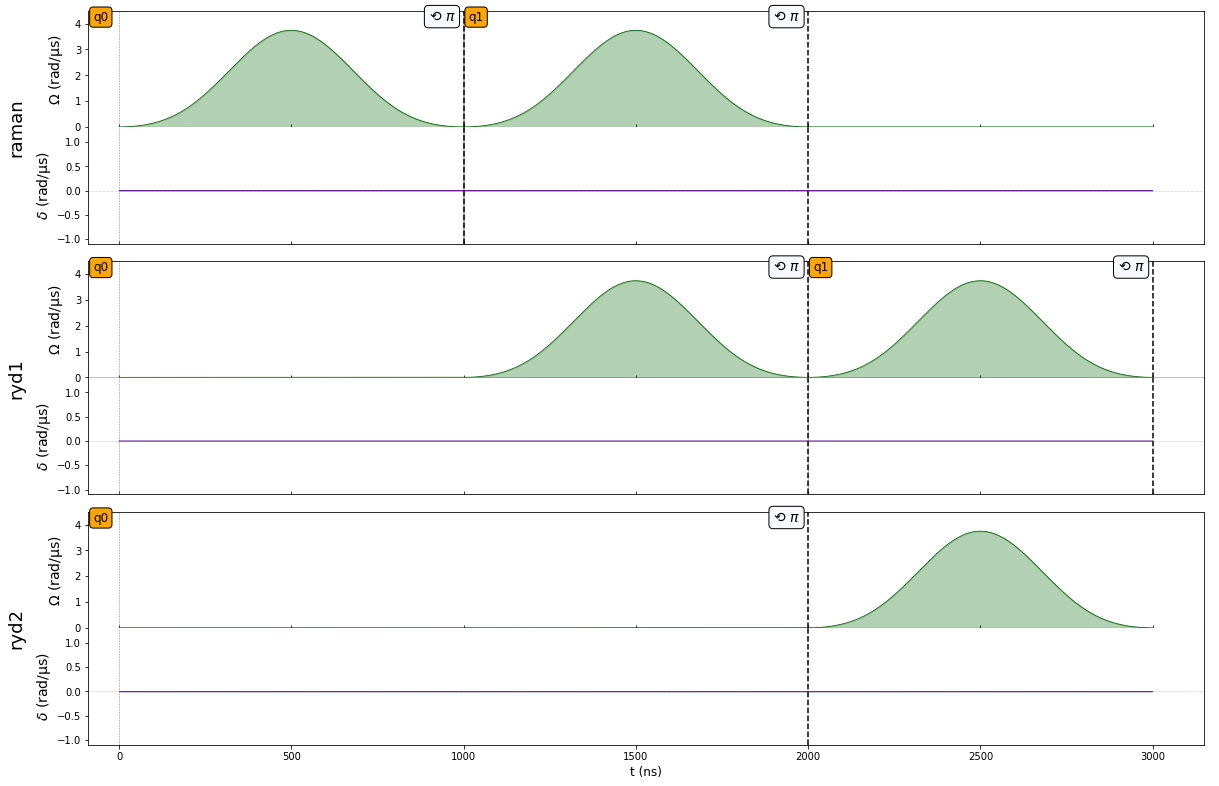

In [14]:
seq.target('q1', 'raman')
seq.add(h, 'raman')
seq.target('q1', 'ryd1')
seq.add(h, 'ryd1')
print(seq)
seq.draw()

We can see how the second pulse on the `raman` and `ryd1` channels are exactly identical to their first one, except for the target. Had the target not changed, they would have their phase shifted by $\pi$, just like we saw earlier. We also see how, this time, the phase shift in `ryd1` does not appear in `ryd2` like before because they have **different targets**. Notice what happens if we also make `ryd2` target `q1`:

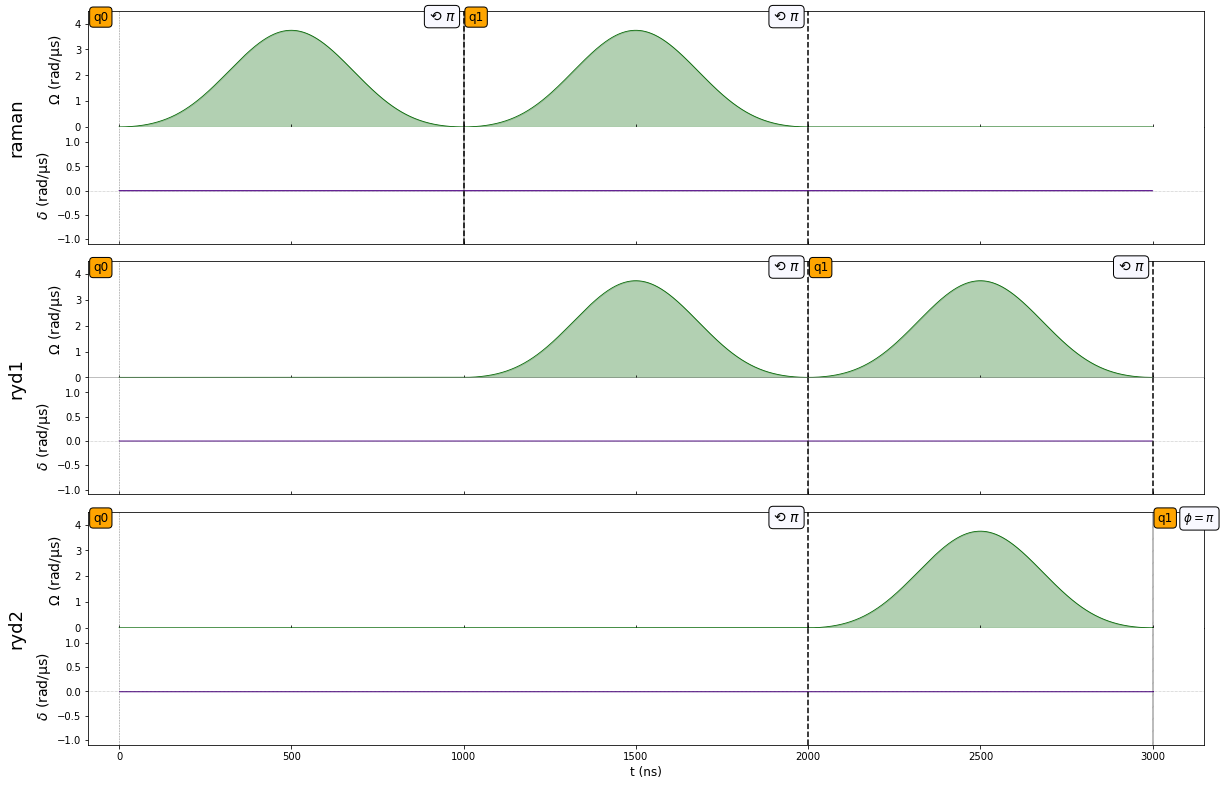

In [15]:
seq.target('q1', 'ryd2')
seq.draw()

As you can see, channel `ryd2` starts off with a phase of $\phi = \pi$, which it picked up from the phase shift induced by the Hadamard on `ryd1`. On the other hand, the Hadamard in the `raman` channel did not affect the phase of `ryd2`(we would have $\phi=0$ in that case) because, again, it acts on a different basis.